<a href="https://colab.research.google.com/github/Ly-xinhgai/recommendation-system-using-knn/blob/main/KNN_CollaborativeFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Xử lý dữ liệu
mục tiêu đề ra là 1 dataframe chứa tên anime, anime_id, user_id, rating
trong đó các anime sẽ là các anime có độ nổi tiếng lớn với cộng đồng member lớn (chỉ lấy khoảng 70%)

bên cạnh đó chỉ lấy các anime chiếu trên tv hoặc movie chiếu rạp

Các user có số lượng đánh giá ít sẽ được bỏ qua (<200)

In [ ]:
import pandas as pd
from google.colab import drive
# Kết nối Google Drive với Colab
drive.mount('/content/drive')

INPUT_DIR = '/content/drive/MyDrive/doan2/data/'
!ls {INPUT_DIR}

# Cấu hình đường dẫn
data_path = INPUT_DIR



# Đọc dữ liệu từ file CSV
anime = pd.read_csv(INPUT_DIR + 'anime.csv')
ratings = pd.read_csv(INPUT_DIR + 'rating.csv')

# 1. Lọc anime theo điều kiện
# Chỉ giữ các anime có type là TV hoặc Movie
filtered_anime = anime[anime['type'].isin(['TV', 'Movie'])]

# Chỉ giữ top 50% anime theo số lượng members
threshold = filtered_anime['members'].quantile(0.5)
filtered_anime = filtered_anime[filtered_anime['members'] > threshold]

# Lọc bỏ các đánh giá có giá trị là -1
ratings = ratings[ratings['rating'] != -1]

# 2. Merge anime và ratings trước
merged_data = ratings.merge(filtered_anime, on='anime_id', suffixes=['_user', ''])
merged_data.rename(columns={'rating_user': 'user_rating'}, inplace=True)
merged_data.rename(columns={'rating': 'average_rating'}, inplace=True)

# 3. Lọc user có số lượng đánh giá ít hơn 500
user_ratings_count = merged_data['user_id'].value_counts()
valid_users = user_ratings_count[user_ratings_count >= 500].index
filtered_merged_data = merged_data[merged_data['user_id'].isin(valid_users)]

# Tính trung bình đánh giá của mỗi user
user_mean_ratings = filtered_merged_data.groupby('user_id')['user_rating'].mean()

# Trừ trung bình đánh giá của mỗi user
filtered_merged_data['rating_normalized'] = filtered_merged_data.apply(
    lambda row: row['user_rating'] - user_mean_ratings[row['user_id']], axis=1
)

# 4. Chọn các cột cần thiết
final_data = filtered_merged_data[['anime_id', 'name', 'user_id', 'user_rating', 'rating_normalized', 'genre', 'average_rating', 'members']]
print(final_data.head())
print("Shape of final data:", final_data.shape)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
anime.csv  anime.gsheet  rating.csv
       anime_id           name  user_id  user_rating  rating_normalized  \
11653         1   Cowboy Bebop      226            8           0.310709   
11654         6         Trigun      226            8           0.310709   
11655        20         Naruto      226            7          -0.689291   
11656        25      Sunabouzu      226            6          -1.689291   
11657        27  Trinity Blood      226            7          -0.689291   

                                                   genre  average_rating  \
11653    Action, Adventure, Comedy, Drama, Sci-Fi, Space            8.82   
11654                             Action, Comedy, Sci-Fi            8.32   
11655  Action, Comedy, Martial Arts, Shounen, Super P...            7.81   
11656  Action, Adventure, Comedy, Ecchi, Sci-Fi, Shounen            7.55   
1165

<ipython-input-26-8c7f4104c218>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_merged_data['rating_normalized'] = filtered_merged_data.apply(


In [ ]:
# Hiển thị kết quả
print(final_data.info())

# Hiển thị số lượng user còn lại sau khi lọc
num_users_left = final_data['user_id'].nunique()
print(f"Số lượng user còn lại sau lọc: {num_users_left}")

# Hiển thị số lượng anime còn lại sau khi lọc
num_anime_left = final_data['anime_id'].nunique()
print(f"Số lượng anime còn lại sau lọc: {num_anime_left}")


<class 'pandas.core.frame.DataFrame'>
Index: 409088 entries, 11653 to 5175300
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   anime_id           409088 non-null  int64  
 1   name               409088 non-null  object 
 2   user_id            409088 non-null  int64  
 3   user_rating        409088 non-null  int64  
 4   rating_normalized  409088 non-null  float64
 5   genre              409088 non-null  object 
 6   average_rating     409088 non-null  float64
 7   members            409088 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 28.1+ MB
None
Số lượng user còn lại sau lọc: 627
Số lượng anime còn lại sau lọc: 2890


In [ ]:
from sklearn.model_selection import train_test_split

# Tạo ánh xạ cho user_id
user_id_mapping = {user_id: idx for idx, user_id in enumerate(final_data['user_id'].unique())}
# Tạo ánh xạ cho anime_id
anime_id_mapping = {anime_id: idx for idx, anime_id in enumerate(final_data['anime_id'].unique())}

# Thay thế user_id và anime_id bằng giá trị được ánh xạ
final_data['user_id'] = final_data['user_id'].map(user_id_mapping)
final_data['anime_id'] = final_data['anime_id'].map(anime_id_mapping)

# Hiển thị lại thông tin sau khi reindex
print(final_data.head())

# Kiểm tra số lượng user và anime sau khi ánh xạ
num_users_reindexed = final_data['user_id'].nunique()
num_anime_reindexed = final_data['anime_id'].nunique()
print(f"Số lượng user sau reindex: {num_users_reindexed}")
print(f"Số lượng anime sau reindex: {num_anime_reindexed}")

# Chia lại dữ liệu thành train và test
train_data, test_data = train_test_split(final_data, test_size=0.2, random_state=42)

# Hiển thị kích thước của tập train và test
print(f"Số lượng bản ghi trong tập train: {len(train_data)}")
print(f"Số lượng bản ghi trong tập test: {len(test_data)}")

user_mean_ratings = final_data.groupby('user_id')['user_rating'].mean()
print("Các cột của user_mean_ratings:")
print(user_mean_ratings[0])




       anime_id           name  user_id  user_rating  rating_normalized  \
11653         0   Cowboy Bebop        0            8           0.310709   
11654         1         Trigun        0            8           0.310709   
11655         2         Naruto        0            7          -0.689291   
11656         3      Sunabouzu        0            6          -1.689291   
11657         4  Trinity Blood        0            7          -0.689291   

                                                   genre  average_rating  \
11653    Action, Adventure, Comedy, Drama, Sci-Fi, Space            8.82   
11654                             Action, Comedy, Sci-Fi            8.32   
11655  Action, Comedy, Martial Arts, Shounen, Super P...            7.81   
11656  Action, Adventure, Comedy, Ecchi, Sci-Fi, Shounen            7.55   
11657                      Action, Supernatural, Vampire            7.44   

       members  
11653   486824  
11654   283069  
11655   683297  
11656    65516  
11657  

<ipython-input-28-6ff45a2b0741>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['user_id'] = final_data['user_id'].map(user_id_mapping)
<ipython-input-28-6ff45a2b0741>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['anime_id'] = final_data['anime_id'].map(anime_id_mapping)


# Bài toán thực hành : Triển khai Hệ thống Gợi ý anime

* Trong Notebook này, chúng ta sẽ triển khai và đánh giá một ***Hệ thống Gợi ý dựa trên Lọc Cộng tác với KNN***

* Để ***triển khai và đánh giá Hệ thống Gợi ý này***, chúng ta sẽ thực hiện các bước sau:
    1. [Đọc Dataset (Huấn luyện và Kiểm tra)](#M1)
    2. [Tính toán Similarity](#M2)
    3. [Tính toán K-láng giềng (K-Neighbors)](#M3)
    4. [Tính toán Dự đoán (Predictions)](#M4)
    5. [Tính toán Gợi ý ](#M5)
    6. [Đánh giá Hệ thống Gợi ý (MAE)](#M6)
    7. [Hệ thống Gợi ý và Đánh giá](#M7)



### Hàm đọc ma trận đánh giá
Hàm này nhận đường dẫn đến file chứa dữ liệu đánh giá và trả về ma trận đánh giá.

In [ ]:
def read_ratings_matrix_from_df(df):
    # Sử dụng numpy array thay vì list of lists
    ratings = np.zeros((NUM_USERS, NUM_ITEMS))

    # Sử dụng vectorized operations thay vì loop
    df_grouped = df.groupby(['user_id', 'anime_id'])['rating_normalized'].first()
    for (user, item), rating in df_grouped.items():
        ratings[int(user)][int(item)] = rating

    return ratings

In [ ]:
import time

def measure_time(task_name, func, *args, **kwargs):
    start_time = time.time()  # Bắt đầu đo thời gian
    result = func(*args, **kwargs)  # Thực thi đoạn code
    end_time = time.time()  # Kết thúc đo thời gian
    print(f"Thời gian chạy cho {task_name}: {end_time - start_time:.2f} giây")
    return result  # Trả về kết quả


<hr>


# <a name="M2"> 2.- Tính toán *Độ tương tự*


* Dưới đây là hàm mà dữ liệu đầu vào là một ma trận đánh giá và một phương pháp đo lường độ tương tự, sẽ trả về ma trận độ tương tự giữa mỗi cặp người dùng.


* Chúng ta cũng triển khai các phương pháp đo lường độ tương tự:
    + MSD
    + Cosine
    + JMSD

In [ ]:
def calculate_similarities(ratings_matrix, similarity_metric):
    # Khởi tạo ma trận numpy
    similarities = np.full((NUM_USERS, NUM_USERS), float('-inf'))

    # Tính toán theo batch để tránh quá tải bộ nhớ
    batch_size = 100
    for i in range(0, NUM_USERS, batch_size):
        batch_end = min(i + batch_size, NUM_USERS)
        if i % batch_size == 0:
            print(f"\tĐang xử lý users {i} đến {batch_end}")

        for j in range(NUM_USERS):
            if j != i:  # Không tính similarity với chính nó
                similarities[i:batch_end, j] = [
                    similarity_metric(ratings_matrix[u], ratings_matrix[j])
                    for u in range(i, batch_end)
                ]

    return similarities

def rating_average(ratings):

    acc = 0
    count = 0
    for id_item in range(len(ratings)):
        if ratings[id_item] != None:
            acc += ratings[id_item]
            count += 1
    return acc / count


def msd_similarity(u, v):
    # Sử dụng numpy operations
    mask = (u != 0) & (v != 0)  # Chỉ xét các rating khác 0
    if not np.any(mask):
        return None

    diff = (u[mask] - v[mask]) / (MAX_RATING - MIN_RATING)
    return 1 - np.mean(diff ** 2)

def cosine_similarity(u, v):
    # Sử dụng numpy operations
    mask = (u != 0) & (v != 0)
    if not np.any(mask):
        return None

    u_masked = u[mask]
    v_masked = v[mask]

    numerator = np.sum(u_masked * v_masked)
    denominator = np.sqrt(np.sum(u_masked ** 2)) * np.sqrt(np.sum(v_masked ** 2))

    return numerator / denominator if denominator != 0 else None

def jmsd_similarity(u, v):
    # Sử dụng numpy operations
    u_nonzero = u != 0
    v_nonzero = v != 0

    intersection = np.sum(u_nonzero & v_nonzero)
    union = np.sum(u_nonzero | v_nonzero)

    if intersection == 0:
        return None

    jaccard = intersection / union
    return jaccard * msd_similarity(u, v)

<hr>


# <a name="M3"> 3.- Tính toán *K-Neighbors*


* Dưới đây là hàm mà dữ liệu đầu vào là một ma trận độ tương tự giữa người dùng và một giá trị 'K' (số lượng láng giềng cần tính), sẽ trả về một ma trận "NUM_USERS x K_NEIGHBORS" chỉ ra láng giềng của mỗi người dùng:

In [ ]:
def calculate_neighbors(similarities_matrix, k_neighbors):
    # Sử dụng numpy operations để tìm k neighbors
    neighbors = np.zeros((NUM_USERS, k_neighbors), dtype=int)

    # Tìm k neighbors cho mỗi user
    for i in range(NUM_USERS):
        # Loại bỏ similarity với chính nó
        sim = similarities_matrix[i].copy()
        sim[i] = float('-inf')

        # Lấy k indices có similarity cao nhất
        neighbors[i] = np.argpartition(sim, -k_neighbors)[-k_neighbors:]

    return neighbors

<hr>


# <a name="M4"> 4.- Tính toán *Dự đoán*


* Dưới đây là một phương pháp tính toán dự đoán về số điểm mà người dùng sẽ đánh giá cho các mục với phương pháp tổng hợp "Trung bình có trọng số":

In [ ]:
def calculate_weighted_average_prediction(ratings_matrix, similarities_matrix, neighbors, user_id=None):

    if user_id is not None:
        # Tính prediction cho một user cụ thể
        predictions = np.zeros(NUM_ITEMS)
        user_ratings = ratings_matrix[user_id]
        user_neighbors = neighbors[user_id]

        for item in range(NUM_ITEMS):
            if user_ratings[item] != 0:
                predictions[item] = user_ratings[item]
                continue

            # Tính weighted average cho items chưa được rate
            numerator = 0.0
            denominator = 0.0

            for neighbor in user_neighbors:
                if ratings_matrix[neighbor][item] != 0:
                    sim = similarities_matrix[user_id][neighbor]
                    if sim is not None:
                        numerator += sim * ratings_matrix[neighbor][item]
                        denominator += abs(sim)

            if denominator != 0:
                predictions[item] = (numerator / denominator)
            else:
                predictions[item] = 0

        return predictions

    # Tính predictions cho tất cả users
    predictions = np.zeros((NUM_USERS, NUM_ITEMS))

    # Xử lý theo batch để tránh quá tải bộ nhớ
    batch_size = 100
    for i in range(0, NUM_USERS, batch_size):
        batch_end = min(i + batch_size, NUM_USERS)
        batch_predictions = np.array([
            calculate_weighted_average_prediction(
                ratings_matrix, similarities_matrix, neighbors, user_id=u
            ) for u in range(i, batch_end)
        ])
        predictions[i:batch_end] = batch_predictions

    return predictions

<hr>


# <a name="M6"> 5.- Tính toán gợi ý


* Dưới đây là một function mà dữ liệu đầu vào là ma trận dự đoán và id người dùng, sẽ trả về n_recommendations mục gợi ý cho người dùng:

In [ ]:
def get_recommendations(predictions_matrix, ratings_matrix, user_id, n_recommendations):
    # Get indices of unrated items for the user
    unrated_items = [i for i in range(len(ratings_matrix[0])) if ratings_matrix[user_id][i] == 0]

    # Sort unrated items by predicted rating, handling potential None values
    recommendations = sorted(unrated_items, key=lambda x: predictions_matrix[x] if predictions_matrix[x] is not None else -float('inf'), reverse=True)

    return recommendations[:n_recommendations]

<hr>


# <a name="M6"> 6.- Đánh giá Hệ thống Gợi ý (MAE)


* Dưới đây là một phương pháp mà dữ liệu đầu vào là ma trận đánh giá và ma trận dự đoán sẽ trả về MAE của Hệ thống Gợi ý:

In [ ]:
def get_mae(ratings_matrix, predictions_matrix):
    # Sử dụng numpy mask để tính MAE
    mask = (ratings_matrix != 0) & (predictions_matrix != None)
    if not np.any(mask):
        return None

    return np.mean(np.abs(ratings_matrix[mask] - predictions_matrix[mask]))

In [ ]:
def get_rmse(ratings_matrix, predictions_matrix):
    # Tạo một mask để chỉ tính toán trên các phần tử không rỗng
    mask = (ratings_matrix != 0) & (~np.isnan(predictions_matrix))
    if not np.any(mask):
        return None

    squared_errors = (ratings_matrix[mask] - predictions_matrix[mask]) ** 2
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse


In [ ]:
def get_mse(ratings_matrix, predictions_matrix):
   mask = (ratings_matrix != 0) & (~np.isnan(predictions_matrix))
   if not np.any(mask):
        return None


<hr>


# <a name="M7">7.- Hệ thống Gợi ý và Đánh giá


* Dưới đây là "Hệ thống Gợi ý", trong đó:
    + Chúng ta sẽ tính toán độ tương tự cho các phương pháp đo lường độ tương tự khác nhau
    + Thực hiện dự đoán cho các số lượng láng giềng khác nhau
    + Đánh giá cho mỗi thí nghiệm các tập dữ liệu huấn luyện và kiểm tra.

In [ ]:
import math
import numpy as np
import pandas as pd

# Số lượng người dùng và items
NUM_USERS = final_data['user_id'].nunique()
NUM_ITEMS = final_data['anime_id'].nunique()

# Điểm tối đa và tối thiểu được đưa ra trong ma trận đánh giá
MIN_RATING = 1
MAX_RATING = 10

#  Đường dẫn của các tập dữ liệu huấn luyện và kiểm tra

# Đọc các tập dữ liệu Huấn luyện và Kiểm tra
train_ratings = read_ratings_matrix_from_df(train_data)
test_ratings = read_ratings_matrix_from_df(test_data)

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def run_experiments():
  SIMILARITIES_METRICS = [('MSD', msd_similarity),
                          ('COSINE', cosine_similarity),
                          ('JMSD', jmsd_similarity)]
  K_NEIGHBORS = [25, 50, 100, 150, 200, 300, 400, 500]
  experiments = []

  for metric in SIMILARITIES_METRICS:
      print(f"{metric[0]}: Tính toán độ tương tự")
      similarities_matrix = calculate_similarities(ratings_matrix=train_ratings,
                                                  similarity_metric=metric[1])

      for k in K_NEIGHBORS:
          print(f"  {k} Láng giềng")
          neighbors_matrix = calculate_neighbors(k_neighbors=k,
                                                similarities_matrix=similarities_matrix)
          # Tính toán dự đoán
          predictions = calculate_weighted_average_prediction(ratings_matrix=train_ratings,
                                                              similarities_matrix=similarities_matrix,
                                                              neighbors=neighbors_matrix)

          # Tính toán MAE
          mae_train = get_mae(ratings_matrix=train_ratings, predictions_matrix=predictions)
          mae_test = get_mae(ratings_matrix=test_ratings, predictions_matrix=predictions)

          # Thêm thí nghiệm vào danh sách
          experiments.append([metric[0], k, mae_train, "Train"])
          experiments.append([metric[0], k, mae_test, "Test"])
          print(f"    Test MAE: {mae_test:.4f}")

  return experiments



experiments = measure_time("Chạy toàn bộ thí nghiệm mục 7", run_experiments)

MSD: Tính toán độ tương tự
	Đang xử lý users 0 đến 100
	Đang xử lý users 100 đến 200
	Đang xử lý users 200 đến 300
	Đang xử lý users 300 đến 400
	Đang xử lý users 400 đến 500
	Đang xử lý users 500 đến 600
	Đang xử lý users 600 đến 627
  25 Láng giềng
    Test MAE: 0.8780
  50 Láng giềng
    Test MAE: 0.8621
  100 Láng giềng
    Test MAE: 0.8544
  150 Láng giềng
    Test MAE: 0.8533
  200 Láng giềng
    Test MAE: 0.8542
  300 Láng giềng
    Test MAE: 0.8579
  400 Láng giềng
    Test MAE: 0.8626
  500 Láng giềng
    Test MAE: 0.8675
COSINE: Tính toán độ tương tự
	Đang xử lý users 0 đến 100
	Đang xử lý users 100 đến 200
	Đang xử lý users 200 đến 300
	Đang xử lý users 300 đến 400
	Đang xử lý users 400 đến 500
	Đang xử lý users 500 đến 600
	Đang xử lý users 600 đến 627
  25 Láng giềng
    Test MAE: 0.9074
  50 Láng giềng
    Test MAE: 0.8774
  100 Láng giềng
    Test MAE: 0.8603
  150 Láng giềng
    Test MAE: 0.8549
  200 Láng giềng
    Test MAE: 0.8539
  300 Láng giềng
    Test MAE: 0.8548

* Chuyển kết quả của các thí nghiệm thành DataFrame:

In [ ]:
# Chuyển kết quả của các thí nghiệm thành DataFrame
df_results = pd.DataFrame.from_records(experiments,
                                       columns=['Metrics', 'K-Neighbors', 'MAE', 'Train/Test'])


* Hiển thị kết quả của các thí nghiệm với dữ liệu kiểm tra:


In [ ]:
pd.pivot_table(df_results[df_results['Train/Test']=='Test'],
               values=['MAE'],
               index=['K-Neighbors'],
               columns=['Metrics'])

MAE                    
Metrics        COSINE      JMSD       MSD
K-Neighbors                              
25           0.907409  0.899628  0.877965
50           0.877435  0.882516  0.862121
100          0.860267  0.871749  0.854388
150          0.854851  0.868979  0.853298
200          0.853871  0.868930  0.854181
300          0.854784  0.869254  0.857869
400          0.856543  0.870897  0.862588
500          0.857022  0.872071  0.867513

* Vẽ kết quả

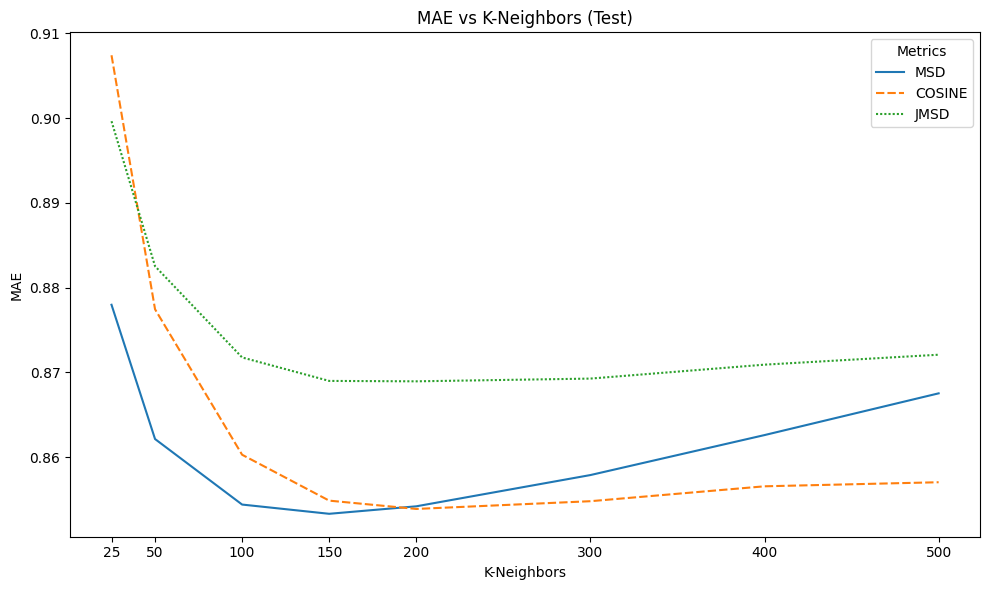

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo một figure
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ MAE với dữ liệu Kiểm tra
sns.lineplot(x="K-Neighbors", y="MAE", hue="Metrics", style="Metrics", data=df_results[df_results['Train/Test'] == 'Test'], ax=ax)

# Thiết lập tiêu đề và nhãn trục
ax.set_title('MAE vs K-Neighbors (Test)')
ax.set_xticks(sorted(df_results['K-Neighbors'].unique()))  # Cập nhật nhãn trục x

# Hiển thị đồ thị
plt.tight_layout()  # Đảm bảo các đồ thị không bị chồng lên nhau
plt.show()


<hr>


# <a name="M8">8.- Hệ thống Gợi ý phim cho người dùng


* Dưới đây là "Hệ thống Gợi ý" phim cho người dùng

* Gợi ý phim cho người dùng thứ 100 với 10 mục:



In [ ]:
def print_recommendations(user_mapping_id, similarities_matrix, neighbors_matrix):
    user_id = user_id_mapping.get(user_mapping_id)
    if user_id is None:
        print(f"Không tìm thấy người dùng với id {user_mapping_id}")
        return

    # Tính ma trận dự đoán
    predictions_matrix = calculate_weighted_average_prediction(
        ratings_matrix=train_ratings,
        similarities_matrix=similarities_matrix,
        neighbors=neighbors_matrix,
        user_id=user_id
    )

    # Lấy danh sách gợi ý
    recommendations = get_recommendations(
        predictions_matrix=predictions_matrix,
        ratings_matrix=train_ratings,
        user_id=user_id,
        n_recommendations=10
    )

    # In tiêu đề bảng
    print(f"\n{'='*90}")
    print(f"Gợi ý phim cho người dùng {user_mapping_id}:")
    print(f"{'STT':<5} {'ID':<10} {'Tên phim':<30} {'Thể loại':<20} {'Điểm TB':<10} {'Dự đoán':<10} {'Thành viên':<10}")
    print(f"{'-'*90}")

    # Duyệt qua các gợi ý và in ra dưới dạng bảng
    for i, item in enumerate(recommendations, start=1):
        prediction = predictions_matrix[item]
        movie_row = final_data[final_data['anime_id'] == item]
        movie_name = movie_row['name'].values[0]
        movie_genre = movie_row['genre'].values[0]
        average_rating = movie_row['average_rating'].values[0]
        members = movie_row['members'].values[0]

        if prediction is not None:
            predicted_score = prediction + user_mean_ratings[user_id]
            print(f"{i:<5} {item:<10} {movie_name[:30]:<30} {movie_genre[:20]:<20} {average_rating:<10.2f} {predicted_score:<10.2f} {members:<10}")
        else:
            print(f"{i:<5} {item:<10} {movie_name[:30]:<30} {movie_genre[:20]:<20} {average_rating:<10.2f} {'N/A':<10} {members:<10}")

    print(f"{'='*90}\n")


In [ ]:

def run_experiments():
  # Tính toán độ tương tự và dự đoán
  similarities_matrix = calculate_similarities(ratings_matrix=train_ratings,
                                              similarity_metric=cosine_similarity)
  neighbors_matrix = calculate_neighbors(k_neighbors=50,
                                          similarities_matrix=similarities_matrix)
  print_recommendations(user_mapping_id=3569, similarities_matrix=similarities_matrix, neighbors_matrix=neighbors_matrix)

measure_time("Thời gian chạy mô hình Colab", run_experiments)


	Đang xử lý users 0 đến 100
	Đang xử lý users 100 đến 200
	Đang xử lý users 200 đến 300
	Đang xử lý users 300 đến 400
	Đang xử lý users 400 đến 500
	Đang xử lý users 500 đến 600
	Đang xử lý users 600 đến 627

Gợi ý phim cho người dùng 3569:
STT   ID         Tên phim                       Thể loại             Điểm TB    Dự đoán    Thành viên
------------------------------------------------------------------------------------------
1     1841       Dr. Slump: Arale-chan          Comedy, Sci-Fi, Shou 7.28       9.68       5330      
2     1142       Dr. Slump                      Comedy, Sci-Fi, Shou 7.11       9.11       8735      
3     2363       Nijiiro Hotaru: Eien no Natsuy Fantasy, Romance, Sl 7.12       8.87       3523      
4     2406       Honoo no Mirage                Action, Drama, Histo 6.74       8.87       12835     
5     2491       Sayonara Ginga Tetsudou 999: A Adventure, Drama, Sc 7.45       8.87       4199      
6     373        Hunter x Hunter (2011)         Action, 